In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow_addons

In [3]:
# Import libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0, ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


 ## Data Loading and Preprocessing

In [4]:
from sklearn.model_selection import KFold


# Define dataset2 paths
data_dir = "/content/drive/MyDrive/SHSU-Projects/Final_files/Knee_Dataset_2_Augmented/train_augmented"


# Define batch size
batch_size = 20
IMAGE_SIZE = (240, 240)
classes = ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']


full_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,  # Specify your class names
    shuffle=True,
    validation_split=None,
    batch_size=batch_size,
    image_size=IMAGE_SIZE,
    seed=1337
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_2_Original/test',
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMAGE_SIZE,
    #validation_split=0.2,
    #subset='test',
    seed=1337
)

def preprocess_image(image, label):
    image = tfa.image.equalize(image)
    return image, label


full_dataset = full_dataset.prefetch(buffer_size=tf.data.AUTOTUNE).map(preprocess_image)


# Convert the dataset to numpy arrays
images, labels = [], []
for img_batch, label_batch in full_dataset:
    images.append(img_batch.numpy())
    labels.append(label_batch.numpy())

images = tf.concat(images, axis=0)
labels = tf.concat(labels, axis=0)

# Specify the number of folds
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Convert NumPy arrays to TensorFlow tensors
images = tf.constant(images)
labels = tf.constant(labels)

Found 6725 files belonging to 5 classes.
Found 89 files belonging to 5 classes.


## Learning Rate Scheduler

List of learning rate:  [6.25e-06, 1.25e-05, 2.5e-05, 5e-05, 0.0001, 9.906850630697068e-05, 9.630873244788883e-05, 9.182350690051133e-05, 8.577994803720606e-05, 7.840323733655778e-05, 6.996822917828477e-05, 6.078920983839031e-05, 5.1208187261806615e-05, 4.1582147932648074e-05, 3.226975564787322e-05, 2.3617987794693376e-05, 1.5949207060660138e-05]


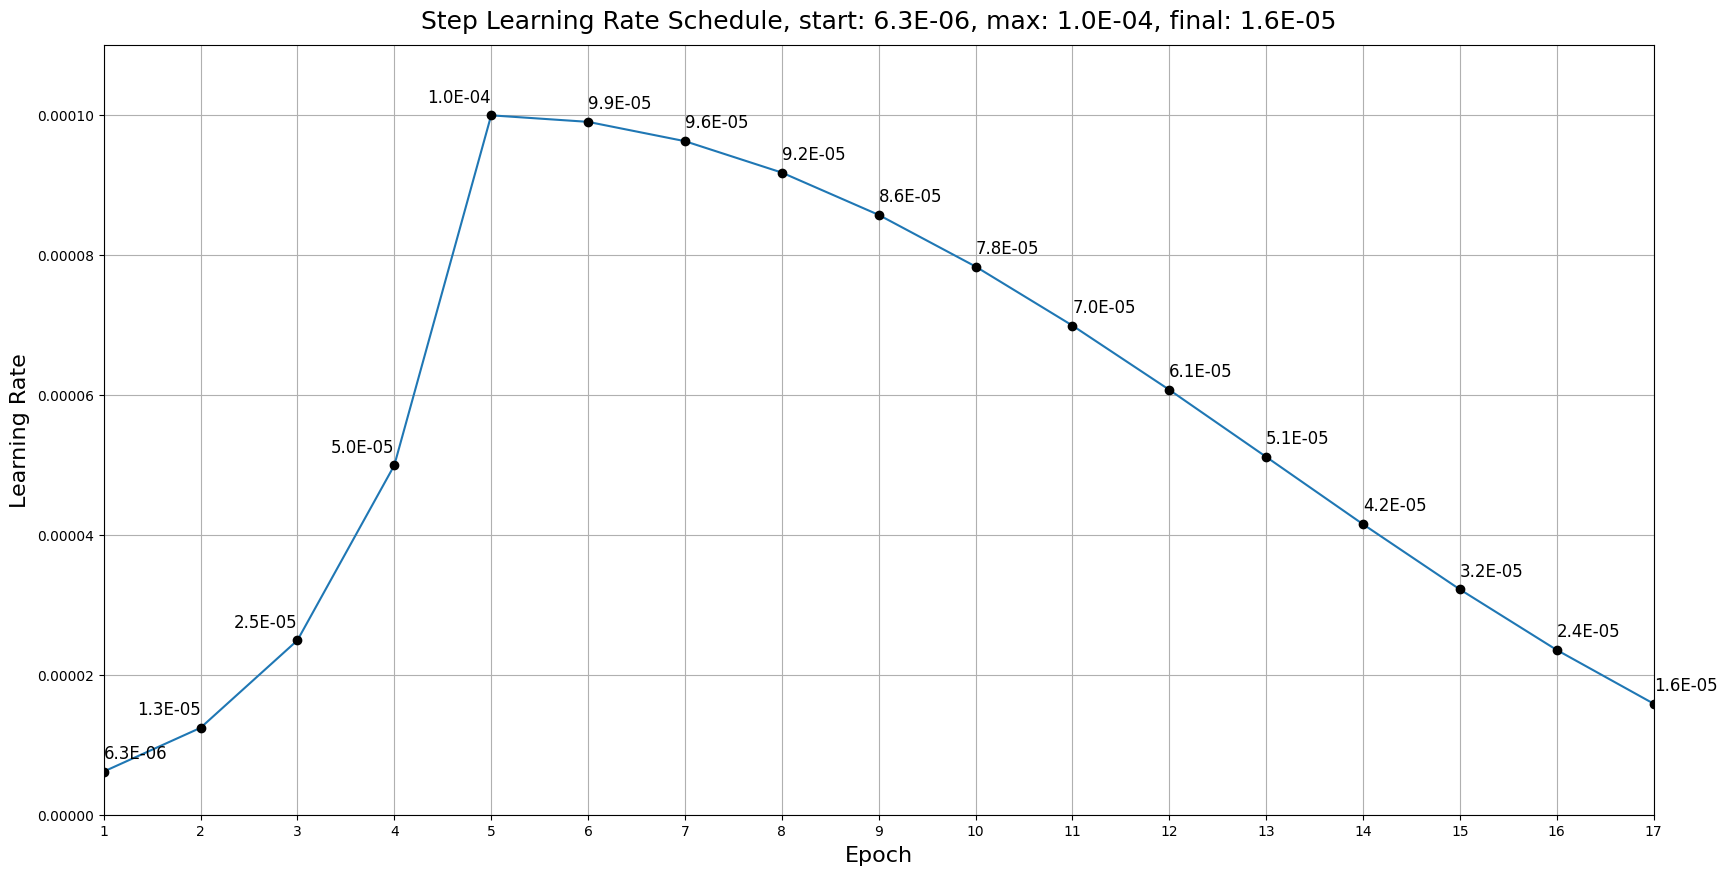

In [5]:
# Import libraries
import math
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

N_EPOCHS = 17
warm_up_ep  = 4
num_cycles  = 0.4
lr_max = 1e-4

def learning_rate_fn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        # exponiancial warmup
        return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max


def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    plt.ylim([0, max(lr_schedule) * 1.1])

    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()




LR_SCHEDULE = [learning_rate_fn(step, num_warmup_steps=warm_up_ep, lr_max=lr_max, num_cycles=num_cycles, num_training_steps=N_EPOCHS) for step in range(N_EPOCHS)]
print('List of learning rate: ', LR_SCHEDULE)

plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)



## Callbacks

In [6]:
#lr_list = [ 0.00001, 0.00006, 0.00003, 0.00002, 0.00002, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001 ]


my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_2_K_fold_CV2.h5', save_best_only=True),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),  # Stop training if no improvement after 7 epochs
    #tf.keras.callbacks.LearningRateScheduler(lambda step: lr_list[step], verbose=0),
    tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-5, verbose=1)
]



## Model Definition and Compile

In [7]:

val_accuracies = []
for fold, (train_indices, val_indices) in enumerate(kfold.split(images)):
    print(f'Fold {fold + 1}/{num_folds}')

    base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    x = base_model.output
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(612, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(210, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

    for layer in base_model.layers:
        layer.trainable = True

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)


    model.compile(
        optimizer= tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
    )


    # Create subsets of the data for training and validation
    train_images, train_labels = tf.gather(images, train_indices), tf.gather(labels, train_indices)
    val_images, val_labels = tf.gather(images, val_indices), tf.gather(labels, val_indices)

    train_dataset_fold = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
    val_dataset_fold = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)


    history = model.fit(
        train_dataset_fold,
        epochs=N_EPOCHS,
        validation_data=val_dataset_fold,
        callbacks=[my_callbacks],
    )

    evaluation = model.evaluate(val_dataset_fold)
    val_accuracies.append(evaluation[1])
    print(f'Validation Accuracy for fold {fold + 1}: {evaluation[1]}')

print("cross validation accuracy: ", sum(val_accuracies)/len(val_accuracies))

Fold 1/5
58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/17
268/269 [============================>.] - ETA: 0s - loss: 19.0743 - accuracy: 0.2164

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


269/269 [==============================] - 26s 55ms/step - loss: 19.0736 - accuracy: 0.2165 - val_loss: 18.7668 - val_accuracy: 0.3561 - lr: 6.2500e-06
Epoch 2/17
269/269 [==============================] - 14s 51ms/step - loss: 18.3183 - accuracy: 0.3342 - val_loss: 17.6921 - val_accuracy: 0.5026 - lr: 1.2500e-05
Epoch 3/17
269/269 [==============================] - 14s 50ms/step - loss: 16.8288 - accuracy: 0.5273 - val_loss: 15.9570 - val_accuracy: 0.5822 - lr: 2.5000e-05
Epoch 4/17
269/269 [==============================] - 14s 51ms/step - loss: 14.5424 - accuracy: 0.6398 - val_loss: 13.2128 - val_accuracy: 0.6684 - lr: 5.0000e-05
Epoch 5/17
269/269 [==============================] - 14s 50ms/step - loss: 11.1517 - accuracy: 0.6801 - val_loss: 10.0763 - val_accuracy: 0.4335 - lr: 1.0000e-04
Epoch 6/17
269/269 [==============================] - 14s 50ms/step - loss: 7.7396 - accuracy: 0.7533 - val_loss: 7.7325 - val_accuracy: 0.4134 - lr: 9.9069e-05
Epoch 7/17
269/269 [===============

## Layers counts

In [8]:
# Create a dictionary to store layer counts
layer_counts = {}

# Iterate through the model's layers
for layer in model.layers:
    layer_type = type(layer).__name__
    if layer_type in layer_counts:
        layer_counts[layer_type] += 1
    else:
        layer_counts[layer_type] = 1

# Print the total layer counts for each layer type
for layer_type, count in layer_counts.items():
    print(f"Layer type '{layer_type}' is applied {count} times.")


Layer type 'InputLayer' is applied 1 times.
Layer type 'Conv2D' is applied 13 times.
Layer type 'MaxPooling2D' is applied 5 times.
Layer type 'BatchNormalization' is applied 1 times.
Layer type 'GlobalAveragePooling2D' is applied 1 times.
Layer type 'Dense' is applied 4 times.
Layer type 'Dropout' is applied 3 times.


## Model Summary

In [9]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [14]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 20 22:49:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    75W / 400W |  17711MiB / 40960MiB |      3%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------